In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

## Конфигурация

In [2]:
config = dict(
    n_epochs=3,
    batch_size=128,
    learning_rate=1e-6,
    loss_margin=2.0,
    loss_alpha=3.0
)

## Dataset

In [3]:
class SiameseDataset(torch.utils.data.Dataset):

    def __init__(self, path, x_file='x.pt', y_file='y.pt'):
        self.x = torch.load(path + '/' + x_file)
        self.y = torch.load(path + '/' + y_file)
        
        if self.x.shape[0] != self.y.shape[0]:
            raise RuntimeError(f'Tensors X and Y must have the same number of items.')

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx][0], self.x[idx][1], self.y[idx]

## Нейронная сеть

In [4]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=4, out_channels=16, kernel_size=9),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=16, out_channels=64, kernel_size=9),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=64, out_channels=256, kernel_size=9),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=256, out_channels=512, kernel_size=8),
            torch.nn.LeakyReLU(),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 2),
        )

    def forward_once(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def forward(self, x_1, x_2):
        out_1 = self.forward_once(x_1)
        out_2 = self.forward_once(x_2)

        return out_1, out_2

## Контрастная функция потерь

In [5]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0, alpha=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.alpha = alpha

    def forward(self, out_1, out_2, y):
        euclidean_distance = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        
        loss_contrastive = torch.mean((1 - y) * torch.pow(euclidean_distance, self.alpha) +
                                      (y) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), self.alpha))
        
        return loss_contrastive

## Обучение нейросети

#### Подготовка Dataset и DataLoader

In [6]:
train_dataset = SiameseDataset(path='siamese_data/train')

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=config['batch_size'])

#### Обучение

In [8]:
model = SiameseNetwork()
criterion = ContrastiveLoss(margin=config['loss_margin'], alpha=config['loss_alpha'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [9]:
def lr_lambda(epoch):
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [10]:
loss_history = []
epoch_loss_history = []
lr_history = []

epoch_progress = trange(config['n_epochs'])
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch + 1}')

    batch_progress = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, (x_1, x_2, y) in batch_progress:
        out_1, out_2 = model(x_1, x_2)

        loss = criterion(out_1, out_2, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())
        
        batch_progress.set_postfix({'loss': loss.item()})

    lr_history.append(optimizer.param_groups[0]['lr'])
    epoch_loss_history.append(np.mean(loss_history[-len(train_dataloader):]))

    scheduler.step()

    epoch_progress.set_postfix({'epoch_mean_loss': epoch_loss_history[-1]})

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

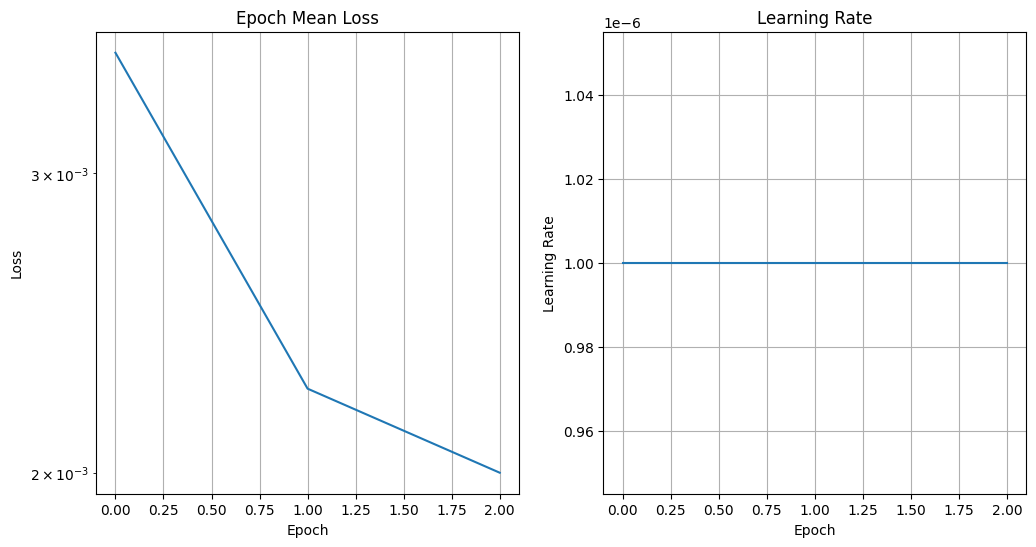

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Epoch Mean Loss plot
axis[0].set_title('Epoch Mean Loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].semilogy()
axis[0].grid()
axis[0].plot(epoch_loss_history)

# Learning Rate plot
axis[1].set_title('Learning Rate')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Learning Rate')
axis[1].grid()
axis[1].plot(lr_history)

## Тестирование нейросети

#### Подготовка Dataset и DataLoader для тестирования

In [12]:
test_dataset = SiameseDataset(path='siamese_data/test')

In [13]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=len(test_dataset))

#### Расчет метрик

In [14]:
def calc_accuracy(y_pred, y):
    return torch.mean(torch.tensor(y_pred == y, dtype=torch.float32))

In [15]:
def calc_f_beta(y_pred, y, beta=1.0):
    t = torch.cat((y_pred, y), 1)

    true_positive = t[(t[:, 0] == 0) & (t[:, 1] == 0), :].size(0)
    false_positive = t[(t[:, 0] == 0) & (t[:, 1] == 1), :].size(0)
    true_negative = t[(t[:, 0] == 1) & (t[:, 1] == 1), :].size(0)
    false_negative = t[(t[:, 0] == 1) & (t[:, 1] == 0), :].size(0)
    print(f'TP = {true_positive}; FP = {false_positive}; TN = {true_negative}; FN = {false_negative}')

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    print(f'precision = {precision}; recall = {recall}')

    f_beta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    print(f'F_{beta} = {f_beta}')
    
    return f_beta

Loss = 0.003316826419904828
Accuracy = 0.9998016953468323
TP = 5040; FP = 0; TN = 5042; FN = 2
precision = 1.0; recall = 0.9996033320111067
F_1.0 = 0.9998016266613767
F_1 = 0.9998016266613767
Distance range between identical objects: [3.7160429201321676e-05, 1.0564833879470825]
Distance range between different objects: [1.6838068962097168, 1161.5556640625]


/var/folders/gv/4nk2tvfd4tjdhkr_hnd4tsz00000gn/T/ipykernel_7091/1450149537.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.mean(torch.tensor(y_pred == y, dtype=torch.float32))


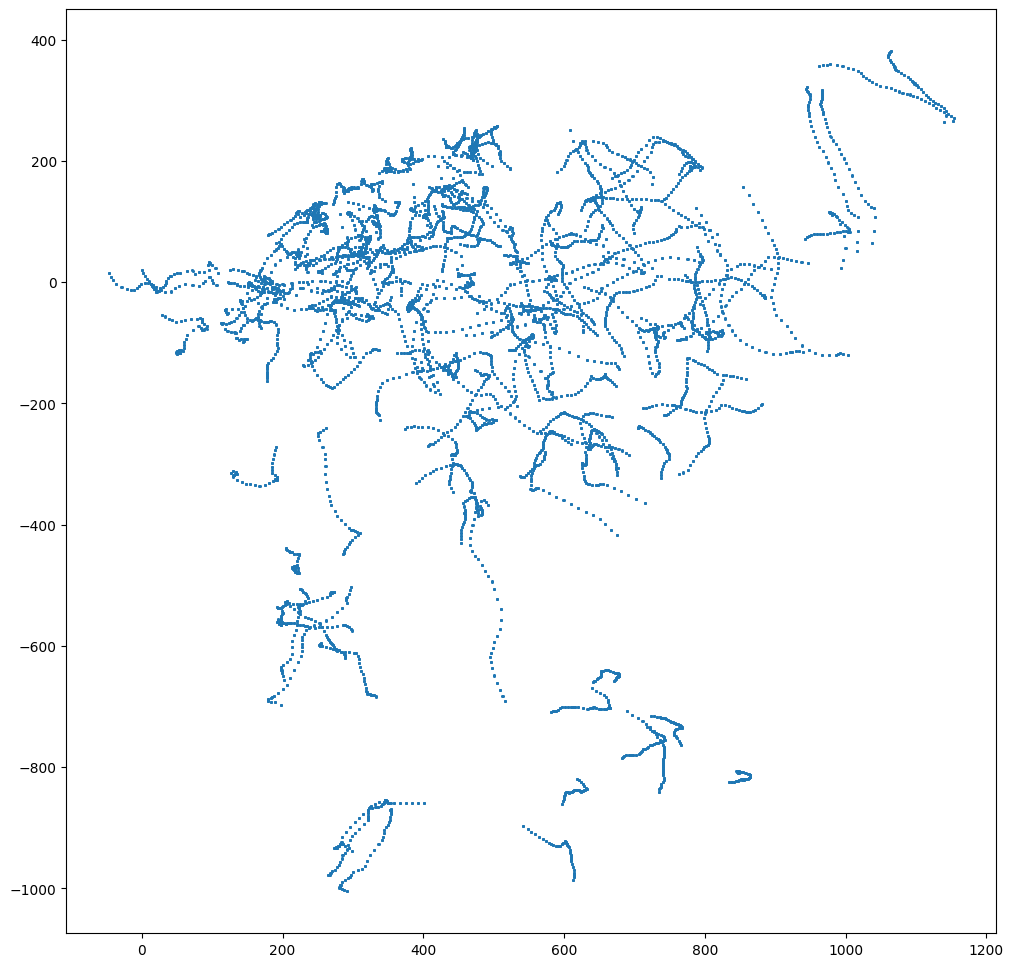

In [16]:
for x_1, x_2, y in test_dataloader:
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        
        loss = criterion(out_1, out_2, y)
        print(f'Loss = {loss.item()}')
        
        dist = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        y_pred = dist >= config['loss_margin']/2
        print(f'Accuracy = {calc_accuracy(y_pred, y)}')
        print(f'F_1 = {calc_f_beta(y_pred, y)}')

        X = torch.cat((y, dist), 1)
        print(f'Distance range between identical objects: [{X[X[:, 0] == 0, :][:, 1].min()}, {X[X[:, 0] == 0, :][:, 1].max()}]')
        print(f'Distance range between different objects: [{X[X[:, 0] == 1, :][:, 1].min()}, {X[X[:, 0] == 1, :][:, 1].max()}]')

        outs = torch.cat((out_1, out_2), 0)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.scatter(outs[:, 0], outs[:, 1], s=1)
        plt.show()

## Отладка результатов

In [17]:
debug = False

In [18]:
debug_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               shuffle=True,
                                               batch_size=1)

In [19]:
if debug:
    for i, (x_1, x_2, y) in enumerate(debug_dataloader):
        with torch.inference_mode():
            out_1, out_2 = model(x_1, x_2)
            
            dist = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)

            loss = criterion(out_1, out_2, y)
            
            if False:
                print(f'Example {i}')
                print('x_1:')
                print(x_1)
                print('x_2:')
                print(x_2)
                print(f'Actual: {y.item()}')
                print(f'out_1 = {out_1}')
                print(f'out_2 = {out_2}')
                print(f'd(out_1, out_2) = {dist.item()}')
                print(f'loss = {loss.item()}')
                print()

                _ = input()